In [3]:
from src.rl.env import NeuralEnv
from src.nn_env.model import TStransformer
from src.nn_env.transformer import Transformer
from src.rl.rewards import RewardSender

import torch

# torch device state
print("torch device avaliable : ", torch.cuda.is_available())
print("torch current device : ", torch.cuda.current_device())
print("torch device num : ", torch.cuda.device_count())

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:{}".format(str(3))
else:
    device = 'cpu'

# 0D parameters
cols_0D = [
    '\\q0', '\\q95', '\\ipmhd', '\\kappa', 
    '\\tritop', '\\tribot','\\betap','\\betan',
    '\\li', '\\WTOT_DLM03'
]

# else diagnostics
cols_diag = [
    '\\ne_inter01', '\\ne_tci01', '\\ne_tci02', '\\ne_tci03', '\\ne_tci04', '\\ne_tci05',
]

# control value / parameter
cols_control = [
    '\\nb11_pnb','\\nb12_pnb','\\nb13_pnb',
    '\\RC01', '\\RC02', '\\RC03',
    '\\VCM01', '\\VCM02', '\\VCM03',
    '\\EC2_PWR', '\\EC3_PWR', 
    '\\ECSEC2TZRTN', '\\ECSEC3TZRTN',
    '\\LV01'
]

seq_len = 16
pred_len = 4

pred_cols = cols_0D

# predictor
model = Transformer(
    input_dim = len(cols_0D) + len(cols_control),
    feature_dim = 128, 
    seq_len = seq_len, 
    n_layers = 4, 
    n_heads = 8, 
    dim_feedforward = 512, 
    dropout = 0.25, 
    pred_len = pred_len,
    output_dim = len(pred_cols),
    RIN = True        
)

model.to(device)
model.load_state_dict(torch.load("./weights/Transformer_seq16_dis4_best.pt"))

# reward 
targets_dict = {
    "\\betap" : 3.0,
    "\\betan" : 4.0,
    "\\q95" : 4.0,
    "\\q0" : 1.0
}

reward_sender = RewardSender(targets_dict, total_cols = cols_0D + cols_control)

env = NeuralEnv(predictor=model, device = device, reward_sender = reward_sender, seq_len = 21, pred_len = 3)

torch device avaliable :  True
torch current device :  0
torch device num :  4


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

df = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_extend.csv").reset_index()
df_disruption = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List.csv", encoding='euc-kr').reset_index()

# nan interpolation
df.interpolate(method = 'linear', limit_direction = 'forward')

# columns for use
ts_cols = cols_0D + cols_control

# float type
for col in ts_cols:
    df[col] = df[col].astype(np.float32)
    
df[cols_control] = df[cols_control].fillna(0)

df[cols_0D] = df[cols_0D].fillna(method = 'ffill')

scaler = RobustScaler()
df[ts_cols] = scaler.fit_transform(df[ts_cols].values)

df_shot = df[df.shot == 18156]
df_shot.head()

,index,time,shot,\q0,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,...,\TS_EDGE7:EDGE7_NE,\TS_EDGE8:EDGE8_NE,\TS_EDGE9:EDGE9_NE,\TS_EDGE10:EDGE10_NE,\TS_EDGE11:EDGE11_NE,\TS_EDGE12:EDGE12_NE,\TS_EDGE13:EDGE13_NE,\TS_EDGE14:EDGE14_NE,\TS_EDGE15:EDGE15_NE,frame_idx
248209,248209,0.000000,18156,226.400101,0.734357,-6.459929,0.542748,4.746996,-8.604465,-6.479645,...,7.390264e+21,1.103687e+22,3.163104e+21,9.632385e+21,4.466228e+22,-7.062761e+22,1.051886e+21,-1.425331e+22,NaN,0
248210,248210,0.019048,18156,210.940140,0.799791,-6.166759,0.237298,4.230034,-8.066546,-6.007341,...,6.806800e+21,1.015384e+22,2.914383e+21,8.915231e+21,4.114415e+22,-6.483132e+22,9.688003e+20,-1.304972e+22,NaN,4
248211,248211,0.038095,18156,196.218765,0.857500,-5.885434,-0.049120,3.742515,-7.557341,-5.561381,...,6.254798e+21,9.319105e+21,2.679008e+21,8.234592e+21,3.781529e+22,-5.935990e+22,8.902076e+20,-1.191517e+22,NaN,8
248212,248212,0.057143,18156,182.217560,0.907746,-5.615630,-0.317065,3.283589,-7.076055,-5.141022,...,5.733387e+21,8.531315e+21,2.456612e+21,7.589516e+21,3.467048e+22,-5.420402e+22,8.159826e+20,-1.084765e+22,NaN,12
248213,248213,0.076190,18156,168.918137,0.950792,-5.357021,-0.567092,2.852406,-6.621900,-4.745517,...,5.241699e+21,7.789115e+21,2.246830e+21,6.979049e+21,3.170452e+22,-4.935434e+22,7.460008e+20,-9.845148e+21,NaN,16


In [5]:
init_indices = df_shot[df_shot.time >= 1.0].index[0:21].values
init_state = df_shot[cols_0D].loc[init_indices].values
init_action = df_shot[cols_control].loc[init_indices].values

In [6]:
import torch

init_state = torch.from_numpy(init_state)
init_action = torch.from_numpy(init_action)
env.update_init_state(init_state, init_action)

In [7]:
# reset
state = env.reset()
print("state : ", state.size())
print(state)

state :  torch.Size([1, 21, 10])
tensor([[[-0.2462, -0.6201, -0.0873, -2.3022, -1.2656, -1.5584, -0.8653,
          -1.0152,  0.4383, -0.3671],
         [-0.2860, -0.6348, -0.1549, -2.3324, -1.3211, -1.5498, -0.8611,
          -1.0110,  0.5047, -0.3343],
         [-0.2708, -0.6272, -0.2179, -2.3373, -1.3560, -1.5381, -0.8533,
          -1.0041,  0.5128, -0.3052],
         [-0.2275, -0.5901, -0.2612, -2.3065, -1.3514, -1.5264, -0.8444,
          -0.9988,  0.4853, -0.2913],
         [-0.1689, -0.5323, -0.2762, -2.2455, -1.3111, -1.5114, -0.8340,
          -0.9927,  0.4337, -0.2929],
         [-0.1034, -0.4682, -0.2563, -2.1662, -1.2470, -1.4874, -0.8206,
          -0.9812,  0.3652, -0.3061],
         [-0.0464, -0.4123, -0.2050, -2.0836, -1.1743, -1.4548, -0.8057,
          -0.9646,  0.3013, -0.3271],
         [-0.0282, -0.3781, -0.1441, -2.0196, -1.1140, -1.4264, -0.7968,
          -0.9531,  0.2903, -0.3526],
         [-0.0774, -0.3777, -0.0968, -1.9949, -1.0864, -1.4150, -0.8013,
      

In [9]:
next_indices = df_shot[df_shot.time >= 1.0].index[21:42].values
next_action = df_shot[cols_control].loc[next_indices].values
next_action = torch.from_numpy(next_action)

print("next action : ", next_action.size())

next action :  torch.Size([21, 14])


In [10]:
next_state, reward, done, _ = env.step(next_action)

exp t : 0.019


In [11]:
print("next_state : ", next_state.size())
print("reward : ", reward)
print("done : ", done)

next_state :  torch.Size([1, 1, 10])
reward :  tensor(0.6329, device='cuda:3', grad_fn=<AddBackward0>)
done :  False


In [32]:
np.unique(df.shot)[-10:-1]

array([21680, 21681, 21682, 21683, 21706, 21730, 21731, 21735, 21747])

In [17]:
print("control values : {}".format(cols_control))
print('# of control values : {}'.format(len(cols_control)))

control values : ['\\nb11_pnb', '\\nb12_pnb', '\\nb13_pnb', '\\RC01', '\\RC02', '\\RC03', '\\VCM01', '\\VCM02', '\\VCM03', '\\EC2_PWR', '\\EC3_PWR', '\\ECSEC2TZRTN', '\\ECSEC3TZRTN', '\\LV01']
# of control values : 14


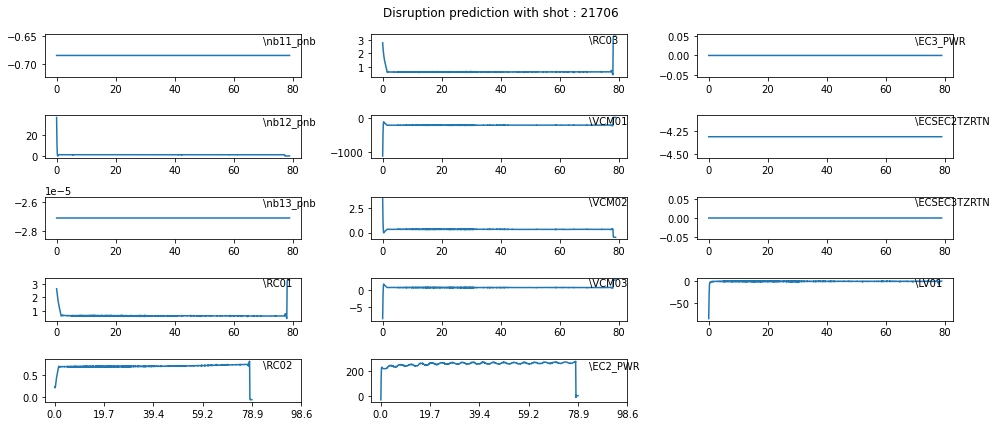

In [38]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

shot_num = 21706
t_control = df[df.shot == shot_num].time
df_control= df[df.shot == shot_num][cols_control]

fig = plt.figure(figsize = (14, 6))
fig.suptitle("Disruption prediction with shot : {}".format(shot_num))
gs = GridSpec(nrows = 5, ncols = 3)

quantile = [0, 0.25, 0.5, 0.75, 1.0, 1.25]
t_quantile = [q * max(t_control) for q in quantile]


idx_i = 0
idx_j = 0

for col in cols_control:
    ax = fig.add_subplot(gs[idx_i,idx_j])
    ax.plot(t_control, df_control[col], label = col)
    ax.text(0.85, 0.8, col, transform = ax.transAxes)
    
    if idx_i < 4:
        idx_i += 1
    else:
        idx_i = 0
        idx_j += 1
        ax.set_xticks(t_quantile)
        ax.set_xticklabels(["{:.1f}".format(t) for t in t_quantile])

fig.tight_layout()
plt.show()

In [50]:
df = pd.read_csv("./dataset/KSTAR_Disruption_ts_data.csv").reset_index()
df[df.shot == 21757]

,index,Unnamed: 0,\q0,time,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,...,\TS_EDGE9:EDGE9_NE,\TS_EDGE10:EDGE10_NE,\TS_EDGE11:EDGE11_NE,\TS_EDGE12:EDGE12_NE,\TS_EDGE13:EDGE13_NE,\TS_EDGE14:EDGE14_NE,\TS_EDGE15:EDGE15_NE,\TS_EDGE16:EDGE16_NE,\TS_EDGE17:EDGE17_NE,shot
160441,160441,11348,4.580232,0.350000,10.360723,-190170.500000,1.185900,0.059735,0.186111,0.362503,...,1.254501e+17,1.258794e+18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757
160442,160442,11349,6.301280,0.400000,11.599979,-205797.781250,1.295234,0.131533,0.170414,0.726007,...,4.490560e+17,8.418201e+17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757
160443,160443,11350,4.563016,0.450000,12.690989,-220706.593750,1.411609,0.186065,0.282362,0.700397,...,1.231443e+19,9.062126e+17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757
160444,160444,11351,4.090829,0.500000,14.154780,-236868.921875,1.596618,0.283113,0.485661,0.746781,...,1.631596e+19,7.503629e+17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757
160445,160445,11352,4.187289,0.550000,14.281720,-252320.578125,1.754285,0.337985,0.681363,0.920257,...,2.739375e+19,4.925200e+17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162204,162204,13111,5.323190,88.500023,8.527727,-378340.312500,1.711371,0.429156,0.865243,1.675989,...,6.752011e+17,3.925989e+17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757
162205,162205,13112,5.323190,88.550018,8.527727,-378340.312500,1.711371,0.429156,0.865243,1.675989,...,6.752011e+17,3.925989e+17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757
162206,162206,13113,5.323190,88.600021,8.527727,-378340.312500,1.711371,0.429156,0.865243,1.675989,...,6.752011e+17,3.925989e+17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757
162207,162207,13114,5.323190,88.650017,8.527727,-378340.312500,1.711371,0.429156,0.865243,1.675989,...,6.752011e+17,3.925989e+17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,21757


In [51]:
df[df.shot == 21757][cols_0D]

,\q0,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,\betan,\li,\WTOT_DLM03,\ne_inter01
160441,4.580232,10.360723,-190170.500000,1.185900,0.059735,0.186111,0.362503,0.190366,1.238463,-5.849707,NaN
160442,6.301280,11.599979,-205797.781250,1.295234,0.131533,0.170414,0.726007,0.373807,0.829674,-3.794372,NaN
160443,4.563016,12.690989,-220706.593750,1.411609,0.186065,0.282362,0.700397,0.343915,0.992275,-1.417584,NaN
160444,4.090829,14.154780,-236868.921875,1.596618,0.283113,0.485661,0.746781,0.337364,1.091425,2.258989,NaN
160445,4.187289,14.281720,-252320.578125,1.754285,0.337985,0.681363,0.920257,0.406599,1.079162,7.548612,NaN
...,...,...,...,...,...,...,...,...,...,...,...
162204,5.323190,8.527727,-378340.312500,1.711371,0.429156,0.865243,1.675989,1.204913,0.684152,146.562210,NaN
162205,5.323190,8.527727,-378340.312500,1.711371,0.429156,0.865243,1.675989,1.204913,0.684152,147.512115,NaN
162206,5.323190,8.527727,-378340.312500,1.711371,0.429156,0.865243,1.675989,1.204913,0.684152,150.197052,NaN
162207,5.323190,8.527727,-378340.312500,1.711371,0.429156,0.865243,1.675989,1.204913,0.684152,149.899719,NaN


In [52]:
df[df.shot == 21757]['\\ne_tci01']

160441      30.916565
160442      37.155258
160443      53.677338
160444      56.657318
160445      34.921242
             ...     
162204   -9005.090820
162205   -8986.970703
162206   -8981.973633
162207   -8986.333008
162208   -8978.750977
Name: \ne_tci01, Length: 1768, dtype: float64

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

df = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_extend.csv").reset_index()
df_disruption = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List.csv", encoding='euc-kr').reset_index()

# nan interpolation
df.interpolate(method = 'linear', limit_direction = 'forward')

,index,time,shot,\q0,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,...,\TS_EDGE7:EDGE7_NE,\TS_EDGE8:EDGE8_NE,\TS_EDGE9:EDGE9_NE,\TS_EDGE10:EDGE10_NE,\TS_EDGE11:EDGE11_NE,\TS_EDGE12:EDGE12_NE,\TS_EDGE13:EDGE13_NE,\TS_EDGE14:EDGE14_NE,\TS_EDGE15:EDGE15_NE,frame_idx
0,0,0.000000,15150,164.502622,24.329033,-418676.250601,2.118868,-20.026145,-20.098111,0.051958,...,-24.125794,-67.427992,-5.394895,269.472409,0.000000,44.799057,0.000000,49.415193,0.0,0
1,1,0.019048,15150,152.770417,22.996761,-370305.910076,2.042015,-18.504508,-18.570738,0.072561,...,-22.064688,-62.177169,-4.922317,248.239687,0.000000,41.292499,0.000000,45.076146,0.0,4
2,2,0.038095,15150,141.622817,21.727002,-324015.609119,1.969383,-17.061292,-17.122099,0.093952,...,-20.122458,-57.204139,-4.477450,228.148024,0.000000,37.973294,0.000000,40.996020,0.0,8
3,3,0.057143,15150,131.044727,20.518143,-279751.674832,1.900857,-15.694431,-15.750119,0.116056,...,-18.295618,-52.501372,-4.059472,209.166075,0.000000,34.836318,0.000000,37.166961,0.0,12
4,4,0.076190,15150,121.021054,19.368574,-237460.434317,1.836325,-14.401856,-14.452720,0.138794,...,-16.580683,-48.061336,-3.667560,191.262493,0.000000,31.876448,0.000000,33.581112,0.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368626,368626,12.361905,21747,4.617370,4.019734,593803.125001,1.865882,0.204431,0.794203,0.665434,...,0.071899,3.015428,0.231127,0.007374,0.070488,0.000000,0.113784,0.000000,0.0,2596
368627,368627,12.380952,21747,4.617370,4.019734,593803.125001,1.865882,0.204431,0.794203,0.665434,...,0.071899,3.015428,0.231127,0.007374,0.070488,0.000000,0.113784,0.000000,0.0,2600
368628,368628,12.400000,21747,4.617370,4.019734,593803.125000,1.865882,0.204431,0.794203,0.665434,...,0.071899,3.015428,0.231127,0.007374,0.070488,0.000000,0.113784,0.000000,0.0,2604
368629,368629,12.419048,21747,4.617370,4.019734,593803.124996,1.865882,0.204431,0.794203,0.665434,...,0.071899,3.015428,0.231127,0.007374,0.070488,0.000000,0.113784,0.000000,0.0,2608


In [54]:
df_disruption.head()

,index,shot,year,tftsrt,tipminf,tTQend,Isdata
0,0,12350,2015,1.5,5.246,5.2248,NaN
1,1,12372,2015,0.7,3.818,3.8026,NaN
2,2,12415,2015,1.9,4.769,4.7450,NaN
3,3,12438,2015,1.1,3.702,3.6826,NaN
4,4,12481,2015,1.9,5.217,5.1923,NaN


In [55]:
print(df_disruption[df_disruption.shot == 21747].head())
tftsrt = df_disruption[df_disruption.shot == 21747].tftsrt.values.item()

      index   shot  year  tftsrt  tipminf  tTQend Isdata
1094   1094  21747  2018   3.724   11.451  11.419    NaN


<AxesSubplot:xlabel='\\ne_tci01', ylabel='Probability'>

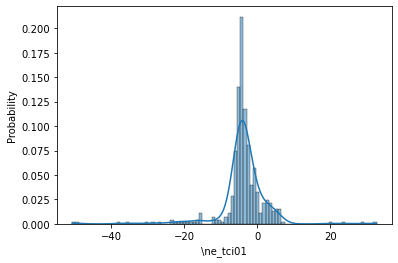

In [56]:
import seaborn as sns
shot_data = df[df.shot == 21747]
sns.histplot(data = shot_data[shot_data['time'] > tftsrt], x = '\\ne_tci01', kde = True, stat = 'probability', discrete = False, common_norm = False)

In [57]:
shot_data['state'] = ['startup' if x < tftsrt else 'steady-state' for x in shot_data['time'] ]

/tmp/ipykernel_3435840/2748257831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shot_data['state'] = ['startup' if x < tftsrt else 'steady-state' for x in shot_data['time'] ]


(0.0, 15.0)

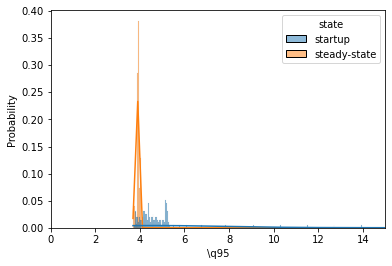

In [58]:
import matplotlib.pyplot as plt
sns.histplot(data = shot_data, hue = 'state', x = '\\q95', kde = True, stat = 'probability', discrete = False, common_norm = False)
plt.xlim([0,15])

(0.0, 2.6)

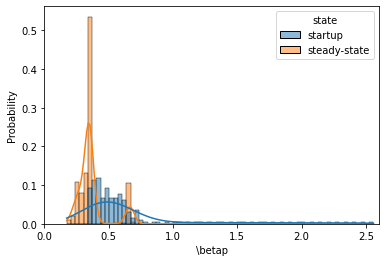

In [59]:
import matplotlib.pyplot as plt
sns.histplot(data = shot_data, hue = 'state', x = '\\betap', kde = True, stat = 'probability', discrete = False, common_norm = False)
plt.xlim([0,2.6])

In [60]:
# total columns list
df.columns

Index(['index', 'time', 'shot', '\q0', '\q95', '\ipmhd', '\kappa', '\tritop',
       '\tribot', '\betap', '\betan', '\li', '\bcentr', '\nb11_pnb',
       '\nb12_pnb', '\nb13_pnb', '\ne_inter01', '\ne_tci01', '\ne_tci02',
       '\ne_tci03', '\ne_tci04', '\ne_tci05', '\RC01', '\RC02', '\RC03',
       '\VCM01', '\VCM02', '\VCM03', '\WTOT_DLM03', '\EC2_PWR', '\EC3_PWR',
       '\ECSEC2TZRTN', '\ECSEC3TZRTN', '\ECSEC4TZRTN', '\LV01',
       '\TS_CORE1:CORE1_TE', '\TS_CORE2:CORE2_TE', '\TS_CORE3:CORE3_TE',
       '\TS_CORE4:CORE4_TE', '\TS_CORE5:CORE5_TE', '\TS_CORE6:CORE6_TE',
       '\TS_CORE7:CORE7_TE', '\TS_CORE8:CORE8_TE', '\TS_CORE9:CORE9_TE',
       '\TS_CORE10:CORE10_TE', '\TS_CORE11:CORE11_TE', '\TS_CORE12:CORE12_TE',
       '\TS_CORE13:CORE13_TE', '\TS_CORE14:CORE14_TE', '\TS_EDGE1:EDGE1_TE',
       '\TS_EDGE2:EDGE2_TE', '\TS_EDGE3:EDGE3_TE', '\TS_EDGE4:EDGE4_TE',
       '\TS_EDGE5:EDGE5_TE', '\TS_EDGE6:EDGE6_TE', '\TS_EDGE7:EDGE7_TE',
       '\TS_EDGE8:EDGE8_TE', '\TS_EDGE9:EDGE9

In [63]:
# NAN value analysis
# case 1. electron density
print("total data : ", len(df))
df[['\\ne_inter01', '\\ne_tci01','\\ne_tci02', '\\ne_tci03', '\\ne_tci05']].isna().sum()

total data :  368631


\ne_inter01    0
\ne_tci01      0
\ne_tci02      0
\ne_tci03      0
\ne_tci05      0
dtype: int64

In [64]:
# case 2. electron temperature
te_cols = [x for x in df.columns if 'TS' in x and 'TE' in x]
ne_cols = [x for x in df.columns if 'TS' in x and 'NE' in x]
df[te_cols].isna().sum()

\TS_CORE1:CORE1_TE      0
\TS_CORE2:CORE2_TE      0
\TS_CORE3:CORE3_TE      0
\TS_CORE4:CORE4_TE      0
\TS_CORE5:CORE5_TE      0
\TS_CORE6:CORE6_TE      0
\TS_CORE7:CORE7_TE      0
\TS_CORE8:CORE8_TE      0
\TS_CORE9:CORE9_TE      0
\TS_CORE10:CORE10_TE    0
\TS_CORE11:CORE11_TE    0
\TS_CORE12:CORE12_TE    0
\TS_CORE13:CORE13_TE    0
\TS_CORE14:CORE14_TE    0
\TS_EDGE1:EDGE1_TE      0
\TS_EDGE2:EDGE2_TE      0
\TS_EDGE3:EDGE3_TE      0
\TS_EDGE4:EDGE4_TE      0
\TS_EDGE5:EDGE5_TE      0
\TS_EDGE6:EDGE6_TE      0
\TS_EDGE7:EDGE7_TE      0
\TS_EDGE8:EDGE8_TE      0
\TS_EDGE9:EDGE9_TE      0
\TS_EDGE10:EDGE10_TE    0
\TS_EDGE11:EDGE11_TE    0
\TS_EDGE12:EDGE12_TE    0
\TS_EDGE13:EDGE13_TE    0
\TS_EDGE14:EDGE14_TE    0
\TS_EDGE15:EDGE15_TE    0
dtype: int64

In [65]:
cols_0D = [
    '\\q0', '\\q95', '\\ipmhd', '\\kappa', 
    '\\tritop', '\\tribot','\\betap','\\betan',
    '\\li', '\\WTOT_DLM03', '\\ne_inter01',
]

# else diagnostics
cols_diag = [
    '\\ne_inter01', '\\ne_tci01', '\\ne_tci02', '\\ne_tci03', '\\ne_tci04', '\\ne_tci05',
]

# control value / parameter
cols_control = [
    '\\nb11_pnb','\\nb12_pnb','\\nb13_pnb',
    '\\RC01', '\\RC02', '\\RC03',
    '\\VCM01', '\\VCM02', '\\VCM03',
    '\\EC2_PWR', '\\EC3_PWR', 
    '\\ECSEC2TZRTN', '\\ECSEC3TZRTN',
    '\\LV01'
]

In [66]:
from tqdm.auto import tqdm

shot_ignore = []
shot_list = np.unique(df.shot)
for shot in tqdm(shot_list, desc = 'extract the null data'):
    df_shot = df[df.shot == shot]
    null_check = df_shot[cols_0D].isna().sum()
    
    for c in null_check:
        if c > 0.5 * len(df_shot):
            shot_ignore.append(shot)
            break

print(len(shot_ignore))

extract the null data: 100%|██████████| 782/782 [00:01<00:00, 535.88it/s]

28


In [67]:
# Electron Temperature analysis : how to use this information for 0D predictor
df[te_cols] = df[te_cols].fillna(0)
df[ne_cols] = df[ne_cols].fillna(0)

Core TE :  ['\\TS_CORE1:CORE1_TE', '\\TS_CORE2:CORE2_TE', '\\TS_CORE3:CORE3_TE', '\\TS_CORE4:CORE4_TE', '\\TS_CORE5:CORE5_TE', '\\TS_CORE6:CORE6_TE', '\\TS_CORE7:CORE7_TE', '\\TS_CORE8:CORE8_TE', '\\TS_CORE9:CORE9_TE', '\\TS_CORE10:CORE10_TE', '\\TS_CORE11:CORE11_TE', '\\TS_CORE12:CORE12_TE', '\\TS_CORE13:CORE13_TE', '\\TS_CORE14:CORE14_TE']


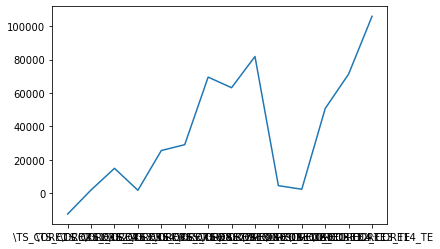

In [70]:
import matplotlib.pyplot as plt

te_cols_core = [x for x in te_cols if 'CORE' in x]
print("Core TE : ", te_cols_core)

Te_edge_core = df[df.shot==21747][te_cols_core].iloc[12]

plt.plot(Te_edge_core)

Edge TE :  ['\\TS_EDGE1:EDGE1_TE', '\\TS_EDGE2:EDGE2_TE', '\\TS_EDGE3:EDGE3_TE', '\\TS_EDGE4:EDGE4_TE', '\\TS_EDGE5:EDGE5_TE', '\\TS_EDGE6:EDGE6_TE', '\\TS_EDGE7:EDGE7_TE', '\\TS_EDGE8:EDGE8_TE', '\\TS_EDGE9:EDGE9_TE', '\\TS_EDGE10:EDGE10_TE', '\\TS_EDGE11:EDGE11_TE', '\\TS_EDGE12:EDGE12_TE', '\\TS_EDGE13:EDGE13_TE', '\\TS_EDGE14:EDGE14_TE', '\\TS_EDGE15:EDGE15_TE']


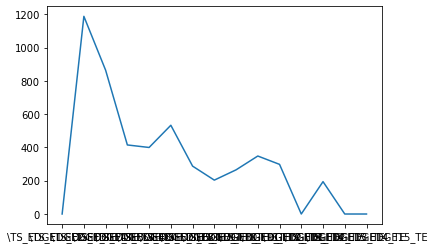

In [72]:
te_cols_edge = [x for x in te_cols if 'EDGE' in x]
print("Edge TE : ", te_cols_edge)

Te_edge_edge = df[df.shot==21747][te_cols_edge].iloc[128]

plt.plot(Te_edge_edge)

Edge NE :  ['\\TS_EDGE1:EDGE1_NE', '\\TS_EDGE2:EDGE2_NE', '\\TS_EDGE3:EDGE3_NE', '\\TS_EDGE4:EDGE4_NE', '\\TS_EDGE5:EDGE5_NE', '\\TS_EDGE6:EDGE6_NE', '\\TS_EDGE7:EDGE7_NE', '\\TS_EDGE8:EDGE8_NE', '\\TS_EDGE9:EDGE9_NE', '\\TS_EDGE10:EDGE10_NE', '\\TS_EDGE11:EDGE11_NE', '\\TS_EDGE12:EDGE12_NE', '\\TS_EDGE13:EDGE13_NE', '\\TS_EDGE14:EDGE14_NE', '\\TS_EDGE15:EDGE15_NE']


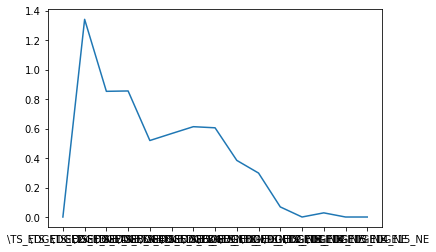

In [73]:
ne_cols_edge = [x for x in ne_cols if 'EDGE' in x]
print("Edge NE : ", ne_cols_edge)

Ne_edge_edge = df[df.shot==21747][ne_cols_edge].iloc[128]

plt.plot(Ne_edge_edge)

In [74]:
Ne_edge_edge

\TS_EDGE1:EDGE1_NE      0.000000
\TS_EDGE2:EDGE2_NE      1.340509
\TS_EDGE3:EDGE3_NE      0.852312
\TS_EDGE4:EDGE4_NE      0.854782
\TS_EDGE5:EDGE5_NE      0.518719
\TS_EDGE6:EDGE6_NE      0.565931
\TS_EDGE7:EDGE7_NE      0.612515
\TS_EDGE8:EDGE8_NE      0.604956
\TS_EDGE9:EDGE9_NE      0.383859
\TS_EDGE10:EDGE10_NE    0.297977
\TS_EDGE11:EDGE11_NE    0.068409
\TS_EDGE12:EDGE12_NE    0.000000
\TS_EDGE13:EDGE13_NE    0.028192
\TS_EDGE14:EDGE14_NE    0.000000
\TS_EDGE15:EDGE15_NE    0.000000
Name: 368105, dtype: float64

Core NE :  ['\\TS_CORE1:CORE1_NE', '\\TS_CORE2:CORE2_NE', '\\TS_CORE3:CORE3_NE', '\\TS_CORE4:CORE4_NE', '\\TS_CORE5:CORE5_NE', '\\TS_CORE6:CORE6_NE', '\\TS_CORE7:CORE7_NE', '\\TS_CORE8:CORE8_NE', '\\TS_CORE9:CORE9_NE', '\\TS_CORE10:CORE10_NE', '\\TS_CORE11:CORE11_NE', '\\TS_CORE12:CORE12_NE', '\\TS_CORE13:CORE13_NE', '\\TS_CORE14:CORE14_NE']


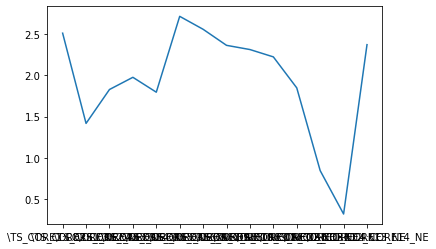

In [75]:
import matplotlib.pyplot as plt

ne_cols_core = [x for x in ne_cols if 'CORE' in x]
print("Core NE : ", ne_cols_core)

Ne_edge_core = df[df.shot==21747][ne_cols_core].iloc[128]

plt.plot(Ne_edge_core)

In [76]:
df['\\TS_CORE_TE_AVG'] = df[te_cols_core].mean(axis = 1)
df['\\TS_CORE_TE_AVG']

0         278869.656120
1         257648.524357
2         237540.308412
3         218515.183216
4         200543.323705
              ...      
368626      2617.571429
368627      2617.571429
368628      2617.571429
368629      2617.571429
368630      2617.571429
Name: \TS_CORE_TE_AVG, Length: 368631, dtype: float64